# Quantum Key Distribution and Eavesdropper

## Contents

1. Ordinary measurement method of eavesdropper
2. Cloned qubit measurement method of eavesdropper (eavesdropper with quantum triplicator)
3. Result of performance evaluation

## 1. Ordinary measurement method of eavesdropper

This example uses the BB84 QKD (quantum key distribution) protocol where Alice sends qbits to Bob. 
Eavesdropper (Eve) uses a measurement in the X-basis or a measurement in the Z-basis for every qbit communication between Alice and Bob.

Alice --> Eve -> Bob

After Alice and Bob remove any bits where Bob measured a different basis than Alice prepared,
there are four cases.

| case | Alice's basis | Eve's basis | Bob's basis | probability | P(Alice==Bob\|case) | P(Alice==Eve\|case) | P(Bob==Eve\|case) |
|:----:|:-------------:|:-----------:|:-----------:|:-----------:|:-------------------:|:-------------------:|:-----------------:| 
| 1    | X-basis       | X-basis     | X-basis     | 1/4         | 1                   | 1                   | 1                 |
| 2    | X-basis       | Z-basis     | X-basis     | 1/4         | 1/2                 | 1/2                 | 1/2               |
| 3    | Z-basis       | X-basis     | Z-basis     | 1/4         | 1/2                 | 1/2                 | 1/2               |
| 4    | Z-basis       | Z-basis     | Z-basis     | 1/4         | 1                   | 1                   | 1                 |

P(Alice == Bob), the probability that Alice's bit is equal to Bob's bit, is
0.75 (=1/4 * 1 +  1/4 * 1/2 + 1/4 * 1/2 + 1/4 * 1).

P(Alice == Eve), the probability that Alice's bit is equal to Eve's bit, is
0.75 (=1/4 * 1 +  1/4 * 1/2 + 1/4 * 1/2 + 1/4 * 1).

P(Bob == Eve), the probability that Bob's bit is equal to Eve's bit, is
0.75 (=1/4 * 1 +  1/4 * 1/2 + 1/4 * 1/2 + 1/4 * 1).

Alice and Bob compare the values of the check bits.
If more than an acceptable number disagree, P(Alice == Bob) < acceptable p, they abort the protocol.
If Alice and Bob decide to proceed the protocol, the rate that Eve succesfully gets Bob's key is P(Bob == Eve).

## 2. Cloned qubit measurement method of eavesdropper (eavesdropper with quantum triplicator)

Measurement is generally an irreversible operation which destroys quantum information.
To suppress the influence of measurement, Eve copies a quantum bit received from Alice to three quantum bits with a quantum triplicator.
Eve sends one quantum bit to Bob and measures the other two quantum bit in the Z-basis and the X-basis.
According to the BB84 QKD, Alice announces Alice's basis of encoding to Bob.
Under the assumption that Eve can captures the Alice's basis, Alice's bit is recoverd by the measurement result corresponding to Alice's basis.

It is impossible to copy perfectly an arbitrary quantum state without introducing errors.
Therefore, Eve can't get Alice's bit without errors.
To evaluate the performance, P(Alice == Bob) and P(Bob == Eve) are calculated below.

In [1]:
# import
import numpy as np
import itertools
from math import pi
import matplotlib.pyplot as plt

#%matplotlib inline

from qiskit import (
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
    execute,
    BasicAer,
    Aer,
    transpile,
    assemble,
)
from qiskit.visualization import plot_histogram, plot_bloch_multivector

print("Imports Successful")


Imports Successful


In [2]:
def calc_theta(p):
    return 2 * np.arccos(np.sqrt(p))


def fill_result(result):
    # order of qbits: (q_n, ..., q1, q0)
    bit_len = len(list(result.keys())[0])
    bit = ["0", "1"]
    key_list = ["".join(bits) for bits in itertools.product(bit, repeat=bit_len)]

    total = sum(result.values())
    result_new = {}
    for k in key_list:
        v = result.get(k)
        result_new[k] = 0 if v is None else v / total
    return result_new


def count_result(result, filter_str):
    bit_list = []
    for bit_str in filter_str:
        if bit_str == "0" or bit_str == "1":
            bit_list.append([bit_str])
        else:
            bit_list.append(["0", "1"])
    key_list = ["".join(bits) for bits in itertools.product(*bit_list)]

    total = 0
    for k in key_list:
        total += result[k]

    return total


In [3]:
def qstate_cloning(qc, q0, q1, q2):
    # input q0
    # output q1
    # output q2

    theta1 = pi / 8 * 2
    theta2 = -np.arcsin(np.sqrt(1.0 / 2 - np.sqrt(2.0) / 3)) * 2
    theta3 = pi / 8 * 2

    # u(theta, phi, lambda)
    # = [ [           cos(theta / 2), - exp(i lambda)         sin(theta / 2)],
    #     [exp(i phi) sin(theta / 2),   exp(i (phi + lambda)) cos(theta / 2)] ]

    qc.barrier()

    angle = 0
    qc.u(theta1, angle, angle, q1)
    qc.cx(q1, q2)
    qc.u(theta2, angle, angle, q2)
    qc.cx(q2, q1)
    qc.u(theta3, angle, angle, q1)

    qc.barrier()

    qc.cx(q0, q1)
    qc.cx(q0, q2)
    qc.cx(q1, q0)
    qc.cx(q2, q0)


def make_qkd_qc(b, zx, p, angle, q_setup):
    theta = calc_theta(p)
    qc = QuantumCircuit(5, 3)
    qc.u(theta, 0, 0, 0)
    if b == 1:
        qc.x(1)
    if zx == 1:
        qc.h(1)
    # control swap (cswap) is used to switch applying a measurement with rate p.
    # - no swapping and applying a measurement with probability p
    # - swapping and applying no measurement with probability 1-p (swap p is defined as 1-p)
    qc.cswap(0, 1, 2)

    qstate_cloning(qc, 1, 3, 4)

    (q_Bob, q_Eva_H, q_Eva_noH) = q_setup
    
    qc.cswap(0, q_Bob, 2)
    if zx == 1:
        qc.h(q_Bob)
    qc.measure(q_Eva_noH, 0)
    qc.h(q_Eva_H)
    qc.measure(q_Eva_H, 1)
    qc.measure(q_Bob, 2)
    return qc


def qkd(b, zx, p, angle, q_setup):
    qc = make_qkd_qc(b, zx, p, angle, q_setup)
    aer_sim = Aer.get_backend("aer_simulator")
    job = aer_sim.run(assemble(qc), shots=4096)
    return job.result().get_counts()


def calc_prob(result):
    total = 0
    for k, v in result.items():
        total += v
    result_tmp = {}
    for k in ["00", "01", "10", "11"]:
        v = result.get(k)
        if v is None:
            result_tmp[k] = 0
        else:
            result_tmp[k] = v / total
    return result_tmp


def calc_statistics(p, angle, q_setup):
    q = {}
    q["z0"] = fill_result(qkd(0, 0, p, angle, q_setup))
    q["z1"] = fill_result(qkd(1, 0, p, angle, q_setup))
    q["x0"] = fill_result(qkd(0, 1, p, angle, q_setup))
    q["x1"] = fill_result(qkd(1, 1, p, angle, q_setup))

    # zx = 0 (z), no h, measurement result is c0
    z0_00 = count_result(q["z0"], "0*0")  
    z0_01 = count_result(q["z0"], "0*1")
    z0_10 = count_result(q["z0"], "1*0")
    z0_11 = count_result(q["z0"], "1*1")

    # zx = 0 (z), no h, measurement result is c0
    z1_00 = count_result(q["z1"], "0*0")
    z1_01 = count_result(q["z1"], "0*1")
    z1_10 = count_result(q["z1"], "1*0")
    z1_11 = count_result(q["z1"], "1*1")

    # zx = 1 (x), h, measurement result is c1
    x0_00 = count_result(q["x0"], "00*")
    x0_01 = count_result(q["x0"], "01*")
    x0_10 = count_result(q["x0"], "10*")
    x0_11 = count_result(q["x0"], "11*")

    # zx = 1 (x), h, measurement result is c1
    x1_00 = count_result(q["x1"], "00*")
    x1_01 = count_result(q["x1"], "01*")
    x1_10 = count_result(q["x1"], "10*")
    x1_11 = count_result(q["x1"], "11*")

    p_acc = (
        1.0 / 4 * count_result(q["z0"], "0**")
        + 1.0 / 4 * count_result(q["z1"], "1**")
        + 1.0 / 4 * count_result(q["x0"], "0**")
        + 1.0 / 4 * count_result(q["x1"], "1**")
    )

    p0_suc = 0
    if z0_00 + z0_10 + z1_00 + z1_10 > 0:
        p0_suc += 1.0 / 2 * ((z0_00 + z1_00) / (z0_00 + z0_10 + z1_00 + z1_10))
    if x0_00 + x0_10 + x1_00 + x1_10 > 0:
        p0_suc += 1.0 / 2 * ((x0_00 + x1_00) / (x0_00 + x0_10 + x1_00 + x1_10))
    p1_suc = 0
    if z0_01 + z0_11 + z1_01 + z1_11 > 0:
        p1_suc += 1.0 / 2 * ((z0_11 + z1_11) / (z0_01 + z0_11 + z1_01 + z1_11))
    if x0_01 + x0_11 + x1_01 + x1_11 > 0:
        p1_suc += 1.0 / 2 * ((x0_11 + x1_11) / (x0_01 + x0_11 + x1_01 + x1_11))

    p0_eve = (
        1.0 / 4 * count_result(q["z0"], "**0")
        + 1.0 / 4 * count_result(q["z1"], "**0")
        + 1.0 / 4 * count_result(q["x0"], "*0*")
        + 1.0 / 4 * count_result(q["x1"], "*0*")
    )
    p1_eve = (
        1.0 / 4 * count_result(q["z0"], "**1")
        + 1.0 / 4 * count_result(q["z1"], "**1")
        + 1.0 / 4 * count_result(q["x0"], "*1*")
        + 1.0 / 4 * count_result(q["x1"], "*1*")
    )
    p_suc = 1.0 / 4 * (z0_00 + z0_11 + z1_00 + z1_11 + x0_00 + x0_11 + x1_00 + x1_11)
    return p_acc, p0_suc, p1_suc, p0_eve, p1_eve, p_suc


def eval_performance(q_setup):
    # q_setup: (qbit of Bob, qbit of Eva in X-basis (H), qbit of Eva in Z-basis (no H))
    p_list = np.linspace(0, 1, 11)
    angle_list = pi * np.linspace(-1, 1, 21)
    p_acc_mat = np.zeros((len(p_list), len(angle_list)))
    p0_suc_mat = np.zeros((len(p_list), len(angle_list)))
    p1_suc_mat = np.zeros((len(p_list), len(angle_list)))
    p0_eve_mat = np.zeros((len(p_list), len(angle_list)))
    p1_eve_mat = np.zeros((len(p_list), len(angle_list)))
    p_suc_mat = np.zeros((len(p_list), len(angle_list)))
    p_idx = 0
    for p in p_list:
        angle_idx = 0
        for angle in angle_list:
            p_acc, p0_suc, p1_suc, p0_eve, p1_eve, p_suc = calc_statistics(p, angle, q_setup)
            p_acc_mat[p_idx, angle_idx] = p_acc
            p0_suc_mat[p_idx, angle_idx] = p0_suc
            p1_suc_mat[p_idx, angle_idx] = p1_suc
            p0_eve_mat[p_idx, angle_idx] = p0_eve
            p1_eve_mat[p_idx, angle_idx] = p1_eve
            p_suc_mat[p_idx, angle_idx] = p_suc
            angle_idx += 1
        p_idx += 1

    return (
        p_list,
        angle_list,
        p_acc_mat,
        p_suc_mat,
    )  # , p0_suc_mat, p1_suc_mat, p0_eve_mat, p1_eve_mat


In [4]:
def plot_suc_vs_acc(p_list, p_acc_mat, p_suc_mat):
    for p_idx in range(len(p_acc_mat)):
        plt.plot(
            p_acc_mat[p_idx], p_suc_mat[p_idx], label=f"swap_p={1-p_list[p_idx]:.1f}"
        )
    plt.plot([0.75], [0.75], marker="o", markersize=10)
    plt.xlim(0.65, 1.00)
    plt.ylim(0.50, 0.85)
    plt.xlabel("P(Alice == Bob)")
    plt.ylabel("P(Bob == Eve)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)


def plot_suc_vs_angle(p_list, angle_list, p_suc_mat):
    for p_idx in range(len(p_acc_mat)):
        plt.plot(angle_list, p_suc_mat[p_idx], label=f"swap_p={1-p_list[p_idx]:.1f}")
    plt.xlabel("theta")
    plt.ylabel("P(Bob == Eve)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)


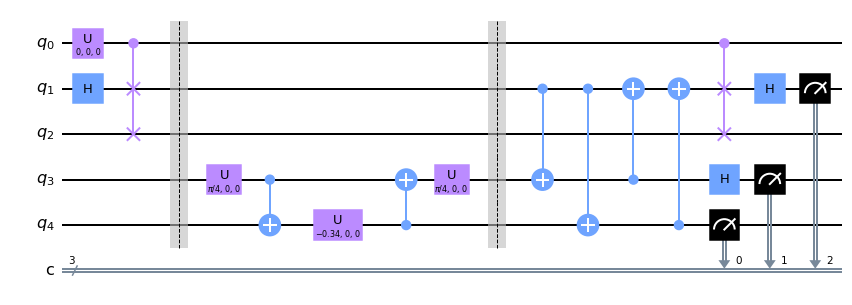

In [5]:
# draw quantum circuit
# b = 0, zx = 1 (X-basis (H)), p = 1, 
# (qbit of Bob, qbit of Eva in X-basis (H), qbit of Eva in Z-basis (no H)) = (q1, q3, q4)
qc = make_qkd_qc(0, 1, 1, pi/4, (1, 3, 4))
qc.draw(output="mpl")


In [6]:
# test: Cloned qubit measurement method of eavesdropper
# p = 1, 
# (qbit of Bob, qbit of Eva in X-basis (H), qbit of Eva in Z-basis (no H)) = (q1, q3, q4)
calc_statistics(1, 0, (1, 3, 4))


(0.6636962890625,
 0.831191462653487,
 0.8358853288443633,
 0.49676513671875,
 0.50323486328125,
 0.83355712890625)

## 3. Result of performance evaluation

Amber colored dot shows the performance of ordinary eavesdropper in Figure.
Figure 3 to 6 show that eavesdropper with quantum triplicator is better than ordinary eavesdropper in regards to P(Alice == Bob) and P(Bob == Eve).

For example, P(Alice == Bob) and P(Bob == Eve) of eavesdropper with quantum triplicator is 0.83 and 0.75 respectively when swap p is 0.0. 

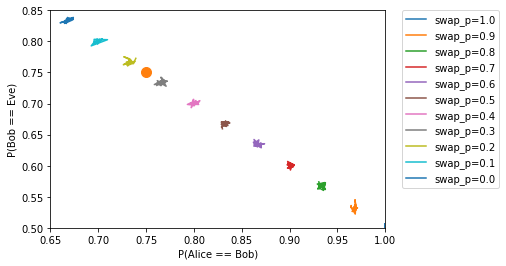

In [7]:
p_list, angle_list, p_acc_mat, p_suc_mat = eval_performance((1, 3, 4))
p_suc_mat = np.abs(p_suc_mat - 0.5) + 0.5

# Figure 1
plot_suc_vs_acc(p_list, p_acc_mat, p_suc_mat)

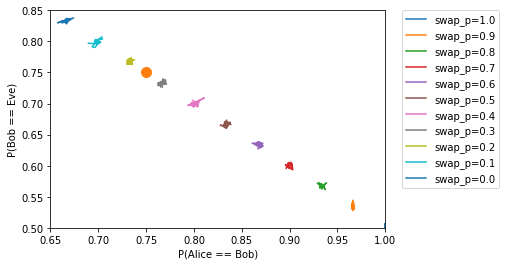

In [8]:
p_list, angle_list, p_acc_mat, p_suc_mat = eval_performance((1, 4, 3))
p_suc_mat = np.abs(p_suc_mat - 0.5) + 0.5

# Figure 2
plot_suc_vs_acc(p_list, p_acc_mat, p_suc_mat)

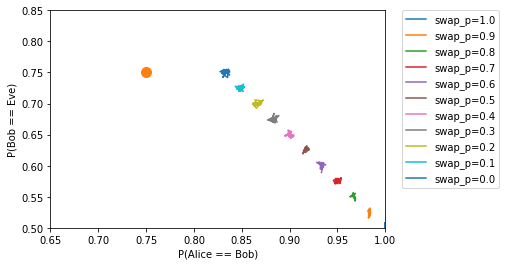

In [9]:
p_list, angle_list, p_acc_mat, p_suc_mat = eval_performance((3, 1, 4))
p_suc_mat = np.abs(p_suc_mat - 0.5) + 0.5

# Figure 3
plot_suc_vs_acc(p_list, p_acc_mat, p_suc_mat)

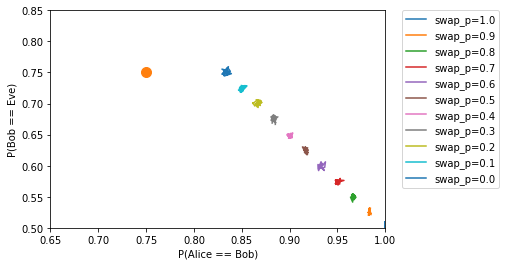

In [10]:
p_list, angle_list, p_acc_mat, p_suc_mat = eval_performance((3, 4, 1))
p_suc_mat = np.abs(p_suc_mat - 0.5) + 0.5

# Figure 4
plot_suc_vs_acc(p_list, p_acc_mat, p_suc_mat)

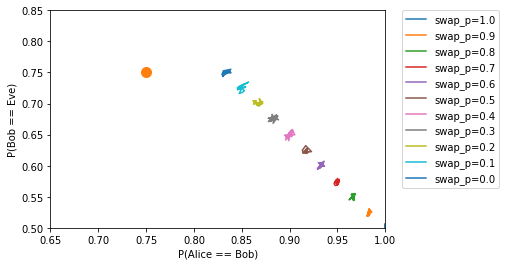

In [11]:
p_list, angle_list, p_acc_mat, p_suc_mat = eval_performance((4, 1, 3))
p_suc_mat = np.abs(p_suc_mat - 0.5) + 0.5

# Figure 5
plot_suc_vs_acc(p_list, p_acc_mat, p_suc_mat)

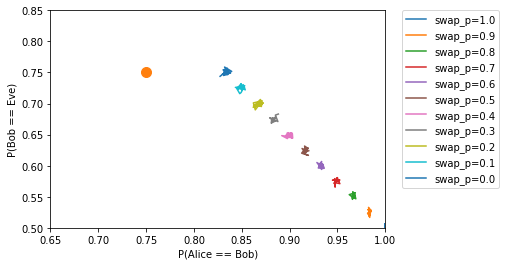

In [12]:
p_list, angle_list, p_acc_mat, p_suc_mat = eval_performance((4, 3, 1))
p_suc_mat = np.abs(p_suc_mat - 0.5) + 0.5

# Figure 6
plot_suc_vs_acc(p_list, p_acc_mat, p_suc_mat)